In [43]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [44]:
data_path = os.environ["DATA"]+"NYC_OK/"

In [45]:
test = pd.read_csv(data_path+"test.csv")

In [56]:
train = pd.read_csv(data_path+"train.csv", nrows=1e6)

In [57]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [58]:
for col_ in train.columns:
    print(col_, train[col_].isna().sum(), train[col_].isna().sum()/train.shape[0])

key 0 0.0
fare_amount 0 0.0
pickup_datetime 0 0.0
pickup_longitude 0 0.0
pickup_latitude 0 0.0
dropoff_longitude 10 1e-05
dropoff_latitude 10 1e-05
passenger_count 0 0.0


2009-01-01 00:00:46 UTC
2015-06-30 23:53:49 UTC


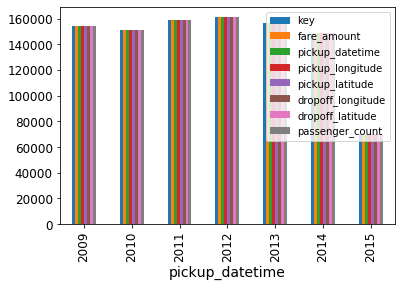

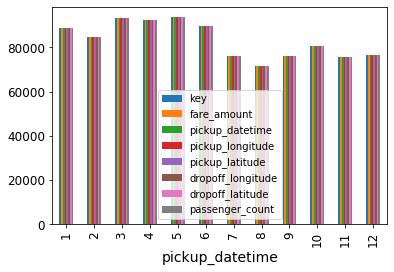

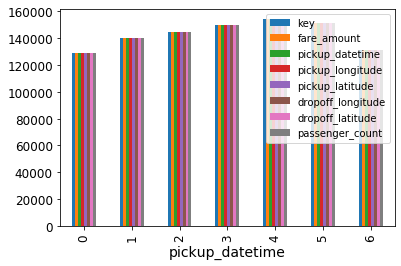

In [59]:
print(train["pickup_datetime"].min())
print(train["pickup_datetime"].max())
train["pickup_datetime"] = train["pickup_datetime"].astype("datetime64")
train.groupby(train["pickup_datetime"].dt.year).count().plot(kind="bar")

train["pickup_datetime"] = train["pickup_datetime"].astype("datetime64")
train.groupby(train["pickup_datetime"].dt.month).count().plot(kind="bar")

train["pickup_datetime"] = train["pickup_datetime"].astype("datetime64")
train.groupby(train["pickup_datetime"].dt.weekday).count().plot(kind="bar")


# Feature Anlysis
- fare_amount: float, bounded, no missing values, noise: outliers

- pickup_datetime: datetime, bounded from 2009-01-01 00:00:46 UTC to 2015-06-30 23:53:49 UTC, uniformly distributed

- pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, : float, bounded , gaussian, noise: outliers


Preprocessing (Removing outliers, and noisy data):
- Lats and lons that do not belong to New York.
- Negative fare.
- Fare greater than 250 (this seems to be noisy data).
- Rides that begin and end in the same location.

In [60]:
def denoise(df):
    # Delimiter lats and lons to NY only
    df = df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
    df = df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
    df = df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df = df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
    # Remove possible outliers
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]
    # Remove inconsistent values
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df

In [63]:
def late_night(row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night(row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
    
    
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)


def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    
    return df


def add_coordinate_features(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)

    return df


def add_distances_features(df):
    # Add distances from airpot and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], lat2, lon2)
    
    return df

def output_submission(raw_test, prediction, id_column, prediction_column, file_name):
    df = pd.DataFrame(prediction, columns=[prediction_column])
    df[id_column] = raw_test[id_column]
    df[[id_column, prediction_column]].to_csv((file_name), index=False)
    print('Output complete')
    
    
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [61]:
TRAIN_PATH = data_path + "train.csv"
TEST_PATH = data_path + "test.csv"
SUBMISSION_NAME = 'submission.csv'

# Model parameters
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001
DATASET_SIZE = 1e6

# Loading values in a memory friendly way
datatypes = {'key': 'str', 
              'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

# Only a fraction of the whole data
train = pd.read_csv(TRAIN_PATH, nrows=DATASET_SIZE, dtype=datatypes, usecols=[1,2,3,4,5,6])
test = pd.read_csv(TEST_PATH)

In [64]:
train = denoise(train)

train = add_time_features(train)
test = add_time_features(test)

add_coordinate_features(train)
add_coordinate_features(test)

train = add_distances_features(train)
test = add_distances_features(test)

train.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,day,hour,weekday,...,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,4.5,-73.844315,40.721317,-73.841614,40.712276,2009,6,15,17,0,...,0.009436,0.011742,0.169225,0.166665,0.139243,0.127501,0.362003,0.355663,0.074368,0.086110
1,16.9,-74.016045,40.711304,-73.979271,40.782005,2010,1,5,16,1,...,0.079693,0.107475,0.012519,0.094957,0.300959,0.334887,0.180259,0.287734,0.204741,0.121276
2,5.7,-73.982735,40.761269,-73.991241,40.750561,2011,8,18,0,3,...,0.013676,0.019215,0.070756,0.051542,0.317614,0.315413,0.263534,0.244319,0.121466,0.140681
3,7.7,-73.987129,40.733143,-73.991570,40.758091,2012,4,21,4,5,...,0.025340,0.029388,0.038236,0.058744,0.293883,0.323272,0.231014,0.251521,0.153986,0.133479
4,5.3,-73.968094,40.768009,-73.956657,40.783764,2010,3,9,7,1,...,0.019468,0.027191,0.092138,0.119329,0.309714,0.314032,0.284915,0.312106,0.100085,0.100421


In [65]:
# Drop unwanted columns
dropped_columns = ['pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude']
train_clean = train.drop(dropped_columns, axis=1)
test_clean = test.drop(dropped_columns + ['key', 'passenger_count'], axis=1)

# peek data
train_clean.head(5)

,fare_amount,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,4.5,2009,6,15,17,0,1,0,0.009041,-0.002701,0.009436,0.011742,0.169225,0.166665,0.139243,0.127501,0.362003,0.355663,0.074368,0.086110
1,16.9,2010,1,5,16,1,1,0,-0.070702,-0.036774,0.079693,0.107475,0.012519,0.094957,0.300959,0.334887,0.180259,0.287734,0.204741,0.121276
2,5.7,2011,8,18,0,3,0,1,0.010708,0.008507,0.013676,0.019215,0.070756,0.051542,0.317614,0.315413,0.263534,0.244319,0.121466,0.140681
3,7.7,2012,4,21,4,5,0,1,-0.024948,0.004440,0.025340,0.029388,0.038236,0.058744,0.293883,0.323272,0.231014,0.251521,0.153986,0.133479
4,5.3,2010,3,9,7,1,0,0,-0.015755,-0.011436,0.019468,0.027191,0.092138,0.119329,0.309714,0.314032,0.284915,0.312106,0.100085,0.100421


In [67]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

train_df, validation_df = train_test_split(train_clean, test_size=0.10, random_state=1)

# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
validation_df = validation_df.drop(['fare_amount'], axis=1)
# Scale data
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
validation_df_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_clean)


In [71]:
from tensorflow import keras


In [74]:
model = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu", input_dim=train_df_scaled.shape[1], activity_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])
adam = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])

In [75]:
print('Dataset size: %s' % DATASET_SIZE)
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % train_df_scaled.shape[1])
print('Features used: %s' % train_df.columns)

Dataset size: 1000000.0
Epochs: 50
Learning rate: 0.001
Batch size: 256
Input dimension: 19
Features used: Index(['year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night',
       'latdiff', 'londiff', 'euclidean', 'manhattan',
       'downtown_pickup_distance', 'downtown_dropoff_distance',
       'jfk_pickup_distance', 'jfk_dropoff_distance', 'ewr_pickup_distance',
       'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance'],
      dtype='object')


In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5120      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [77]:
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_df_scaled, validation_labels), 
                    shuffle=True)

Train on 871054 samples, validate on 96784 samples
Epoch 1/50
871054/871054 [==============================] - 21s 24us/sample - loss: 34.2010 - mae: 3.4722 - val_loss: 17.8736 - val_mae: 2.3963
Epoch 2/50
871054/871054 [==============================] - 19s 21us/sample - loss: 16.1549 - mae: 2.0866 - val_loss: 40.0803 - val_mae: 5.3320
Epoch 3/50
871054/871054 [==============================] - 19s 22us/sample - loss: 15.4551 - mae: 2.0238 - val_loss: 16.0301 - val_mae: 2.0474
Epoch 4/50
871054/871054 [==============================] - 16s 19us/sample - loss: 14.8496 - mae: 1.9796 - val_loss: 15.6432 - val_mae: 1.8475
Epoch 5/50
871054/871054 [==============================] - 16s 19us/sample - loss: 14.3985 - mae: 1.9496 - val_loss: 22.3284 - val_mae: 2.9035
Epoch 6/50
871054/871054 [==============================] - 16s 19us/sample - loss: 14.0910 - mae: 1.9295 - val_loss: 19.6397 - val_mae: 2.3566
Epoch 7/50
871054/871054 [==============================] - 16s 19us/sample - loss: 1

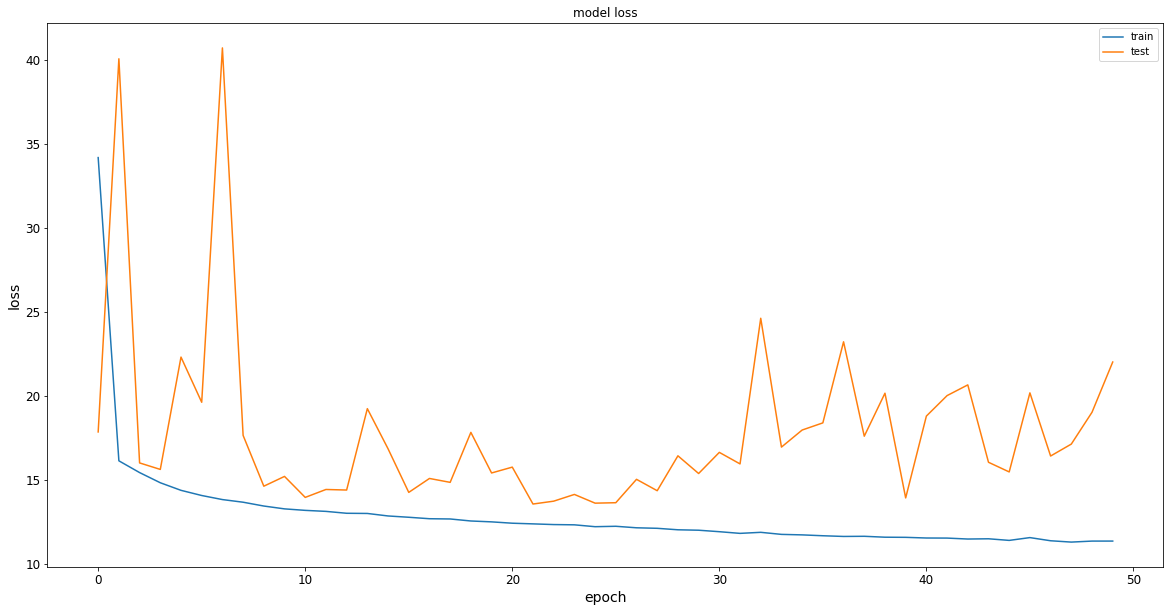

In [78]:
plot_loss_accuracy(history)

In [79]:
# Make prediction
prediction = model.predict(test_scaled, batch_size=128, verbose=1)

9914/9914 [==============================] - 0s 26us/sample


In [80]:
# output prediction
output_submission(test, prediction, 'key', 'fare_amount', SUBMISSION_NAME)

Output complete
